In [ ]:
# ------------------------------------------#
#        Expt 5: Perform a battery of negative inference tests from a single script and plot results, save metadata    
# ------------------------------------------#

Threads.nthreads()
begin
    using LinearAlgebra 
    using Plots
    using FFTW
    using FileIO
    using JLD2
    using DiffEqFlux
    using OrdinaryDiffEq
    using BlockArrays
    using LaTeXStrings
    using SparseArrays
    using BSON
    using Distances
    using DifferentialEquations
    using Optimization
    using OptimizationPolyalgorithms
    using Zygote
    using OptimizationOptimJL
    using OptimizationOptimisers
    using DiffEqSensitivity
    using DelimitedFiles
    using HDF5
    using Plots
    using InvertedIndices
end 

In [2]:
filename = "/home/tschala/research/LANL/case1_1_1D_waveforms_results.h5"
file = h5open(filename, "r")
# Read the dataset
data1d = read(file["data"])

# Close the file
close(file)

In [3]:
filename

"/home/tschala/research/LANL/case1_1_1D_waveforms_results.h5"

In [4]:
println("Size of 1D data matrix:",size(data1d))
println("Shape: [timesteps,spatial locations,waveforms,variables]")

# note that some elements in space a duplicate
# the real spatial size is 100

Size of 1D data matrix:(300, 110, 47, 4)
Shape: [timesteps,spatial locations,waveforms,variables]


In [5]:
# remove duplicate data (both ends of a segment are saved)
data1d_fix = data1d[200:end,Not(11:11:end),:,:];
# remove the unphysical peaks, just replace with linear interpolation
data1d_fix[:,41,:,1] = (data1d_fix[:,40,:,1] + data1d_fix[:,42,:,1])/2;
data1d_fix[:,61,:,1] = (data1d_fix[:,60,:,1] + data1d_fix[:,62,:,1])/2;

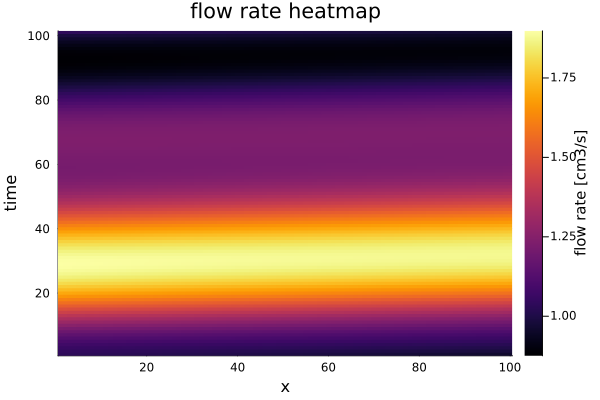

In [6]:
heatmap(data1d_fix[:,:,20,1], title="flow rate heatmap", cbar_title = "flow rate [cm3/s]")
xlabel!("x")
ylabel!("time")


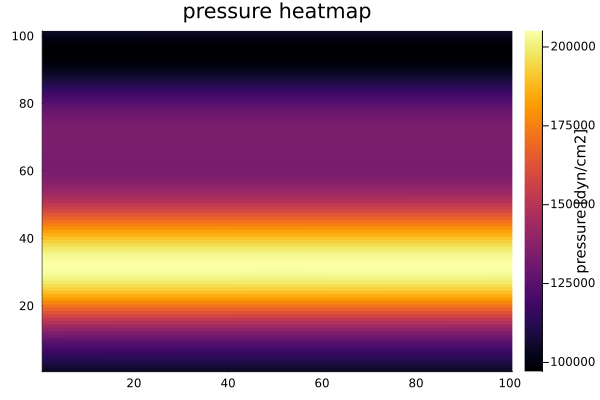

In [7]:
heatmap(data1d_fix[1:end,:,20,2], title="pressure heatmap", cbar_title = "pressure [dyn/cm2]")

In [8]:
begin
    global dt = 0.01                     # time step
    global T = 1                      # total time
    global tsteps = 0.0:dt:T             # discretized time dimension
    global tspan = (0,T)                 # end points of time integration for ODEProbem

    global train_maxiters = 5         # number of iterations of learning
    global learning_rate  = 0.005         # learning rate , currently using PolyOpt default (0.1)


end

0.005

In [9]:
waveforms = 5

5

In [16]:
u0 = data1d_fix[1,:,1:waveforms,1];
u01 = data1d_fix[1,:,1,1];

In [17]:
ytrain2 = data1d_fix[:,:,1:waveforms,1];
ytrain21 = data1d_fix[:,:,1,1];


In [21]:
bc_flow = data1d_fix[:,1,:,1];
bc_flow1 = bc_flow[:,1];

In [13]:
size(ytrain21)

(101, 100)

In [14]:
N = size(u01,1)
# NN embedded in PDE for Differential programming
ann = Chain(
            Dense(N,10,tanh),
            Dense(10,10,tanh),
            Dense(10,10,tanh),
            Dense(10,N));

In [141]:
# flatten parameters in NN for learning.                
p, re = Flux.destructure(ann);
ps = deepcopy(p)
p_size = size(p,1);
println("Number of parameters in neural network: $p_size"); 

Number of parameters in neural network: 2330


In [239]:
# function learn_1DBlood(u, p, t, bc_left)
#     Φ = re(p) # restructure flattened parameter vector into NN architecture.
#     # Apply boundary conditions
#     u[1] = bc_left(t)
#     return Φ(u)
# end



function learn_1DBlood(u, p, t, bc_left)
    Φ = re(p)  # restructure flattened parameter vector into NN architecture.
    
    u_modified = copy(u)  # Create a copy of u
    
    # Apply boundary conditions
    u_modified[1] = bc_left(t)
    
    # Convert u_modified to a regular array
    u_modified_arr = Array(u_modified)
    
    Φ(u_modified_arr)  # Call Φ with modified u_modified_arr
end



learn_1DBlood (generic function with 1 method)

In [240]:
# Define time-dependent boundary conditions
function bc_left(t, bc_flow1)
    # Define the value of the boundary condition at the left boundary for a given time t

    # Find the two closest points in bc_flow1
    #caculate the time index that's closest to time t
    t_index = Int(floor(t / dt)) + 1
    # calculate local time fraction between the grid points
    t_frac = (t - (t_index - 1) * dt) / dt

    # Perform linear interpolation
    # if we are at the last timesteps just copy the value cause t_index+1 will not exist
    if t == T
        bc_interp = bc_flow1[t_index]
        
    else
        bc_interp = (1 - t_frac) * bc_flow1[t_index] + t_frac * bc_flow1[t_index + 1]
    end
    
    return bc_interp
end


# Define time-dependent boundary condition function
bc_left_func(t) = bc_left(t, bc_flow1)

bc_left_func (generic function with 1 method)

In [241]:
#define learning problem.
learn_1DBlood_prob(u01,tspan) =  ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_left_func), u01, tspan, p)


learn_1DBlood_prob (generic function with 1 method)

In [242]:
ode_solver = "Tsit5"
output_dir = "/home/tschala/research/LANL/testNODE"
working_dir = output_dir
# calculate and save the untrained solution 
begin 
    learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_left_func), u01, tspan, p)     # p changes after training   
    if ode_solver == "Tsit5"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    elseif ode_solver == "RK4"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    elseif ode_solver == "Rosenbrock23"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    end
    save_object(output_dir*"/sol_learn_testNODE_untrained.jld2",sol_learn_1DBlood_untrained)
    println("saved untrained solution")
end 

saved untrained solution


In [243]:
prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_left_func), u01, tspan, p) ;
function predict(θ,prob)
    if ode_solver == "Tsit5"
        Array(solve(prob,Tsit5(),p=θ,dt=dt,saveat=dt))
    elseif ode_solver == "RK4"
        Array(solve(prob,RK4(),p=θ,dt=dt,saveat=dt))
    elseif ode_solver == "Rosenbrock23"
        Array(solve(prob,Rosenbrock23(),p=θ,dt=dt,saveat=dt))
    end
end 

predict (generic function with 1 method)

In [244]:
function loss(θ, ytrain21, prob)
    pred = predict(θ, prob)
    l = sum(abs2, pred - ytrain21')
    return l, pred
end


l , pred = loss(ps,ytrain21,prob)

# training optimizer definition
adtype = Optimization.AutoZygote() ;
optf = Optimization.OptimizationFunction((x,p)->loss(x,ytrain21,prob),adtype) ;

In [245]:
path_checkpoint=nothing
optimizer_choice1 = "ADAM"
optimizer_choice2 = "BFGS"

"BFGS"

In [246]:
path_to_working_directory="/home/tschala/research/LANL/juliaDiffProgExample/"

include("$path_to_working_directory/src/numerical_derivatives.jl");
include("$path_to_working_directory/src/train_utils.jl");

In [247]:
# process user choices

if !isdir(working_dir)
    mkdir(working_dir)
end
output_dir = working_dir*"/output/"
cd(working_dir) #switch to working directory
if !isdir(output_dir)
    mkdir(output_dir)
end
println("optimizer 1 is $optimizer_choice1")
if !isnothing(optimizer_choice2)
    println("optimizer 2 is $optimizer_choice2 optimizer")
end

println("ODE Time integrator selected:", ode_solver)


optimizer 1 is ADAM
optimizer 2 is BFGS optimizer
ODE Time integrator selected:Tsit5


In [248]:
# restart training from previaous checkpoint if it exists, else start 
# fresh training.
if !isnothing(path_checkpoint)
    checkpoint_exists = isfile(path_checkpoint)
    if checkpoint_exists
        println("Checkpoint exists!")
        ckpt_restart = jldopen(path_checkpoint,"r")
        res1 = ckpt_restart["ckpt"]
        uinit = copy(res1.u)
    else
        println("ckpt path given, but no file found!")
    end
else
    uinit = deepcopy(ps)
    println("Fresh training initialized")
end

Fresh training initialized


In [249]:
n_epochs = 50
list_loss_train = []
for j in 1:n_epochs
    loss_tot = 0.0
    for i in 1:size(ytrain2,3)
        
        # Define time-dependent boundary condition function
        bc_left_func(t) = bc_left(t, bc_flow[:,i])
        prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_left_func), u01, tspan, p);
#         l , pred = loss(uinit,ytrain2[:,:,i],prob)
        optf = Optimization.OptimizationFunction((x,p)->loss(x,ytrain2[:,:,i],prob),adtype) ;
        println("Start training epoch ",j)
        println("Using $optimizer_choice1 optimizer")
        println("Sum of params:", sum(uinit))
        uinit = train_loop(uinit,adtype,optf,train_maxiters,learning_rate,optimizer_choice1)
        println("Sum of params:", sum(uinit))
        if !isnothing(optimizer_choice2)
            println("Switching to $optimizer_choice2 optimizer")

            uinit = train_loop(uinit,adtype,optf,train_maxiters,learning_rate,optimizer_choice2)

            println("Sum of params:", sum(uinit))


            println("Completed training:" ,i)
        else
            println("Completed training:" ,i)
        end

        prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_left_func), u01, tspan, p);
        l , pred = loss(uinit,ytrain2[:,:,i],prob)
        loss_tot = loss_tot + l
        println("Final BFGS loss:",l)

    end
    
    push!(list_loss_train, loss_tot/size(ytrain2,3))
    println("Epoch ", j, " mean loss:", loss_tot/size(ytrain2,3))
end

Start training epoch 1
Using ADAM optimizer
Sum of params:-9.545283
Max iters:5
Choosing ADAM Optimizer.


LoadError: Mutating arrays is not supported -- called setindex!(Vector{Float64}, ...)
This error occurs when you ask Zygote to differentiate operations that change
the elements of arrays in place (e.g. setting values with x .= ...)

Possible fixes:
- avoid mutating operations (preferred)
- or read the documentation and solutions for this error
  https://fluxml.ai/Zygote.jl/latest/limitations


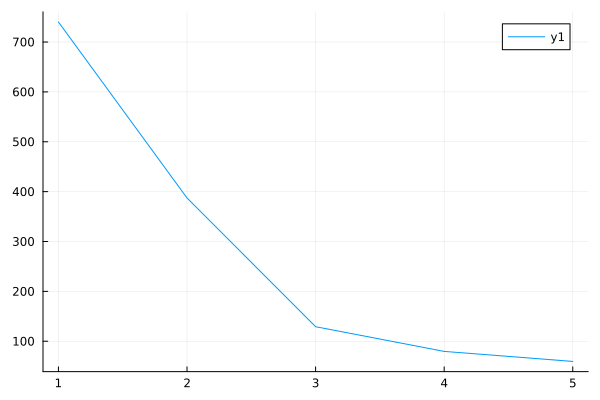

In [131]:
plot(list_loss_train)

In [47]:
sol_untrained = load("/home/tschala/research/LANL/testNODE/sol_learn_testNODE_untrained.jld2");

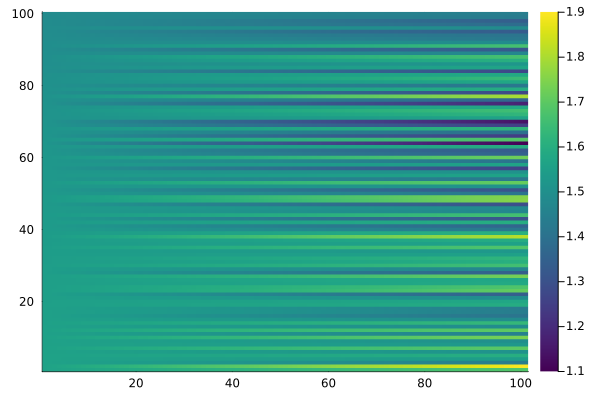

In [48]:
heatmap(sol_untrained["single_stored_object"], color=:viridis)

### Load the final learnt parameters and do inference ###

saved trained solution


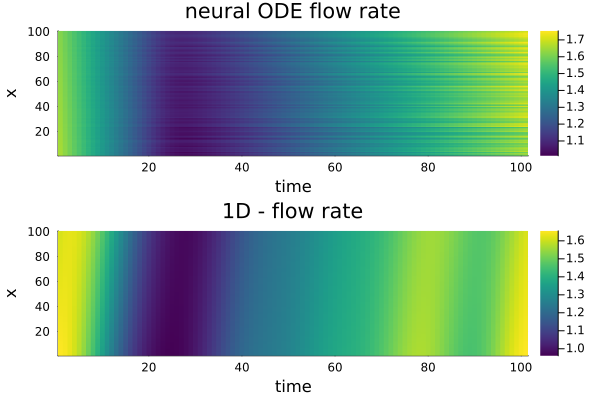

In [133]:
p_learn = load("/home/tschala/research/LANL/testNODE/ptrained_BFGS.jld2")
#waveform to evaluate
wv = 5
u01 = u0[:,wv]

begin 
    learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem(learn_1DBlood, u01, tspan,p_learn["p"])     # p changes after training   
    if ode_solver == "Tsit5"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    elseif ode_solver == "RK4"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    elseif ode_solver == "Rosenbrock23"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    end
    save_object(output_dir*"/sol_learn_testNODE_trained.jld2",sol_learn_1DBlood_untrained)
    println("saved trained solution")
end

sol_learn = load("/home/tschala/research/LANL/testNODE/output/sol_learn_testNODE_trained.jld2");

plot1 = heatmap(sol_learn["single_stored_object"][:,:], color=:viridis, title = "neural ODE flow rate")
xlabel!("time")
ylabel!("x")

plot2 = heatmap(ytrain2[:,:,wv]', title="1D - flow rate", color=:viridis)
xlabel!("time")
ylabel!("x")

plot(plot1,plot2,layout = (2, 1))

saved trained solution


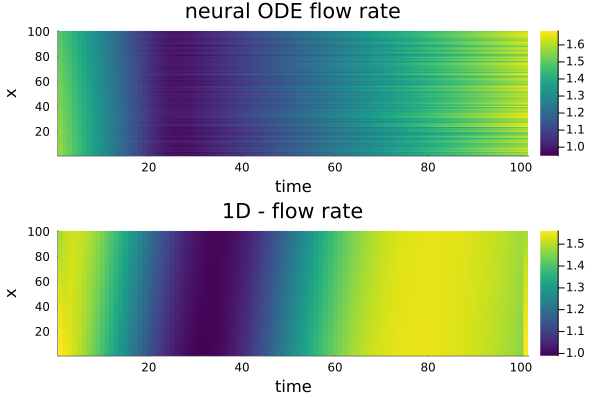

In [134]:
p_learn = load("/home/tschala/research/LANL/testNODE/ptrained_BFGS.jld2")
#waveform to evaluate
wv = 1
u01 = u0[:,wv]

begin 
    learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem(learn_1DBlood, u01, tspan,p_learn["p"])     # p changes after training   
    if ode_solver == "Tsit5"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    elseif ode_solver == "RK4"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    elseif ode_solver == "Rosenbrock23"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    end
    save_object(output_dir*"/sol_learn_testNODE_trained.jld2",sol_learn_1DBlood_untrained)
    println("saved trained solution")
end

sol_learn = load("/home/tschala/research/LANL/testNODE/output/sol_learn_testNODE_trained.jld2");

plot1 = heatmap(sol_learn["single_stored_object"][:,:], color=:viridis, title = "neural ODE flow rate")
xlabel!("time")
ylabel!("x")

plot2 = heatmap(ytrain2[:,:,wv]', title="1D - flow rate", color=:viridis)
xlabel!("time")
ylabel!("x")

plot(plot1,plot2,layout = (2, 1))